In [145]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt

import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.preprocessing import MinMaxScaler
from sklearn.cross_validation import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.svm import LinearSVC, LinearSVR
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import mean_squared_error, accuracy_score, precision_score, recall_score
%matplotlib inline

Data from: [http://www.seanlahman.com/baseball-archive/statistics/](http://www.seanlahman.com/baseball-archive/statistics/)

Data dictionary available here: [http://www.seanlahman.com/files/database/readme2017.txt](http://www.seanlahman.com/files/database/readme2017.txt)

In [235]:
players = pd.read_csv('data/People.csv')
batting = pd.read_csv('data/Batting.csv')

In [236]:
print("There are {0} players in the dataset.".format(players.shape[0]))
print("There are {0} batting records in the dataset.".format(batting.shape[0]))

There are 19370 players in the dataset.
There are 104324 batting records in the dataset.


Let's calculate average runs per season per player

In [237]:
avg_runs = pd.DataFrame(batting.groupby(['playerID']).R.mean())

We can check the average runs (per season) for Bryce Harper:

In [238]:
avg_runs.loc['harpebr03']

R    84.5
Name: harpebr03, dtype: float64

In [239]:
df = players.set_index('playerID').join(avg_runs, how='left')

Let's focus on just players who actually have scored runs:

In [240]:
df = df[df['R'] > 0]

In [241]:
print("There are {0} players who scored runs.".format(df.shape[0]))

There are 13596 players who scored runs.


Let's generate dummy variables for whether the player bats and throws righthanded, lefthanded, or both:

In [242]:
bats_dummies = pd.get_dummies(df.bats, prefix='bats')
throws_dummies = pd.get_dummies(df.throws, prefix='throws')

In [243]:
df = df.join(bats_dummies)
df = df.join(throws_dummies)

Let's take a look at the distribution of runs using a kernel density estimator:

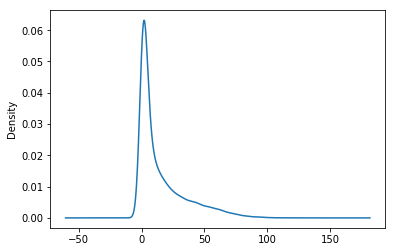

In [244]:
df['R'].plot(kind='kde')

In [245]:
total_median_runs = df['R'].median()
print("On average, players we're considering scored {0} runs per season.".format(round(total_median_runs,2)))

On average, players we're considering scored 6.0 runs per season.


### Regression

Let's focus just on the features we think will be predictive of runs:

- birth month
- weight
- height
- batting hand
- throwing hand

In [246]:
df = df.reset_index()
df = df[['birthMonth','weight','height','bats_B','bats_L','bats_R','throws_L','throws_R', 'R']].dropna()
X = df[['birthMonth','weight','height','bats_B','bats_L','bats_R','throws_L','throws_R']]
y = df['R']

Now let's split our data into training and test sets:

In [247]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [248]:
results = sm.OLS(y_train, X_train).fit()

In [249]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      R   R-squared:                       0.401
Model:                            OLS   Adj. R-squared:                  0.400
Method:                 Least Squares   F-statistic:                     869.5
Date:                Mon, 06 Aug 2018   Prob (F-statistic):               0.00
Time:                        12:28:57   Log-Likelihood:                -45468.
No. Observations:               10420   AIC:                         9.095e+04
Df Residuals:                   10412   BIC:                         9.101e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
birthMonth     0.0189      0.054      0.351      0.7

We can generate predictions on our test data and score the results:

In [250]:
preds = results.predict(X_test)

Mean Absolute Error:

In [251]:
metrics.mean_absolute_error(y_test, preds)

14.823720739572197

In [252]:
sum(abs(preds - y_test))/len(y_test)

14.823720739572211

### Classification

#### Naive Bayes

In [255]:
def above_avg(runs, median):
    if runs > median:
        return 1
    else:
        return 0

df['R_'] = df['R'].apply(lambda x: above_avg(x, total_median_runs))

In [256]:
X = df[['birthMonth','weight','height','bats_B','bats_L','bats_R','throws_L','throws_R']]
y = df['R_']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [257]:
nb = MultinomialNB()
start_time = time.time()
nb.fit(X_train, y_train)
y_pred = nb.predict(X_test)
end_time = time.time()
acc = accuracy_score(y_test, y_pred)
pre = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
print('Accuracy: {}'.format(round(acc, 3)))
print('Precision: {}'.format(round(pre, 3)))
print('Recall: {}'.format(round(rec, 3)))
print('{} seconds'.format(round(end_time - start_time, 3)))

Accuracy: 0.56
Precision: 0.575
Recall: 0.48
0.005 seconds


#### Logistic Regression

In [259]:
logreg = LogisticRegression()
start_time = time.time()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
end_time = time.time()
acc = accuracy_score(y_test, y_pred)
pre = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
print('Accuracy: {}'.format(round(acc, 3)))
print('Precision: {}'.format(round(pre, 3)))
print('Recall: {}'.format(round(rec, 3)))
print('{} seconds'.format(round(end_time - start_time, 3)))

Accuracy: 0.626
Precision: 0.642
Recall: 0.582
0.045 seconds


#### Support Vector Machine (SVM)

In [268]:
svmclf = LinearSVC()
start_time = time.time()
svmclf.fit(X_train, y_train)
y_pred = svmclf.predict(X_test)
end_time = time.time()
acc = accuracy_score(y_test, y_pred)
pre = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
print('Accuracy: {}'.format(round(acc, 3)))
print('Precision: {}'.format(round(pre, 3)))
print('Recall: {}'.format(round(rec, 3)))
print('{} seconds'.format(round(end_time - start_time, 3)))

Accuracy: 0.497
Precision: 0.0
Recall: 0.0
0.494 seconds


/Users/brandon/anaconda/envs/ddl/lib/python3.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


#### Random Forest

In [262]:
rfclf = RandomForestClassifier(n_estimators=100)
start_time = time.time()
rfclf.fit(X_train, y_train)
y_pred = rfclf.predict(X_test)
end_time = time.time()
acc = accuracy_score(y_test, y_pred)
pre = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
print('Accuracy: {}'.format(round(acc, 3)))
print('Precision: {}'.format(round(pre, 3)))
print('Recall: {}'.format(round(rec, 3)))
print('{} seconds'.format(round(end_time - start_time, 3)))

Accuracy: 0.574
Precision: 0.576
Recall: 0.581
0.794 seconds


One of the benefits of random forests is that we can determine the relative importance of each feature:

In [264]:
features = [col for col in X_train]

feature_imp = pd.DataFrame({'feature':features, 'importance':rfclf.feature_importances_}) \
                .sort_values(by='importance', ascending = False)
feature_imp.head(10)

,feature,importance
1,weight,0.470144
0,birthMonth,0.267134
2,height,0.198279
5,bats_R,0.016636
7,throws_R,0.014293
6,throws_L,0.013766
4,bats_L,0.012104
3,bats_B,0.007643
